In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load Dataset

In [3]:
import mlflow
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector
from hcmus.data import LbsDataset
from hcmus.models import FasterRCNNWrapper

In [4]:
mlflow.set_tracking_uri(appconfig.MLFLOW_TRACKING_URI)
mlflow.set_experiment(appconfig.MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='/mlflow/mlruns/1', creation_time=1742697703421, experiment_id='1', last_update_time=1742697703421, lifecycle_stage='active', name='ItemIdentification', tags={}>

In [5]:
torch_device = "cpu"
train_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
)
train_dataset = LbsDataset(train_connector, device=appconfig.TORCH_DEVICE, augmentation=True)
train_loader = train_dataset.get_dataloader(shuffle=True, batch_size=1)

Loading tasks:   4%|▍         | 4/100 [00:06<02:25,  1.51s/it]
2025-03-23 14:57:34.161 | INFO     | hcmus.data._lbs_dataset:__init__:33 - Number of labels: 203
2025-03-23 14:57:34.161 | INFO     | hcmus.data._lbs_dataset:__init__:34 - Number of data points: 1591


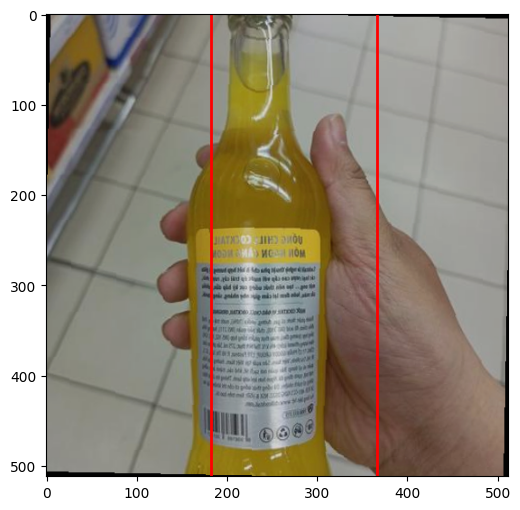

In [6]:
from hcmus.utils import viz_utils
tensor, target = train_dataset[1]
image = train_dataset.tensor_to_image(tensor)
viz_utils.draw_boxes(image, target["boxes"].cpu())

# 2. Finetune Model

In [8]:
model = FasterRCNNWrapper(len(train_dataset._labels), device=torch_device)

2025-03-23 14:57:41.069 | INFO     | hcmus.models._faster_rcnn:__init__:22 - Use torch device: cpu


In [12]:
model.train(train_loader, hyper_params={
    "num_epochs": 16,
    "lr": 1e-4,
    "momentum": 0.9,
    "weight_decay": 1e-5
})

2025-03-23 15:03:20.731 | INFO     | hcmus.models._faster_rcnn:train:58 - Epoch 1/16 - Training loss: 5.5327


🏃 View run persistent-lamb-903 at: http://jimica.ddns.net:5000/#/experiments/1/runs/fb2001033ce2469f93d914c481c6aace
🧪 View experiment at: http://jimica.ddns.net:5000/#/experiments/1


OSError: [Errno 30] Read-only file system: '/mlflow'